In [9]:
import cv2 as cv
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
from plotPerColumnDistribution import plotPerColumnDistribution
import math

sciezki = ['raw-img/kon', 'raw-img/krowa', 'raw-img/kura', 'raw-img/owca', 
         'raw-img/pies']

nazwy_klas = ['Kon', 'Krowa', 'Kura', 'Owca', 'Pies']



train_photos = []
train_labels = []
desired_shape = (32, 32)

print("Rozpoczeto ladowanie obrazow...")

def fillArr(sciezka_idx):
    biblioteka = sciezki[sciezka_idx]
    for filename in os.listdir(biblioteka):
        f = os.path.join(biblioteka, filename)
        # checking if it is a file
        if os.path.isfile(f):
            train_labels.append(sciezka_idx)
            image = Image.open(f)
            image = image.resize(desired_shape)
            photo_array = np.array(image)
            #print(photo_array.shape)
            train_photos.append(photo_array)

for i in range(0, 5):
    fillArr(i)

    
train_photos = np.array(train_photos)
train_photos = train_photos / 255
train_labels = np.array(train_labels)
print("Zakonczono ladowanie obrazow...")

Rozpoczeto ladowanie obrazow...
Zakonczono ladowanie obrazow...


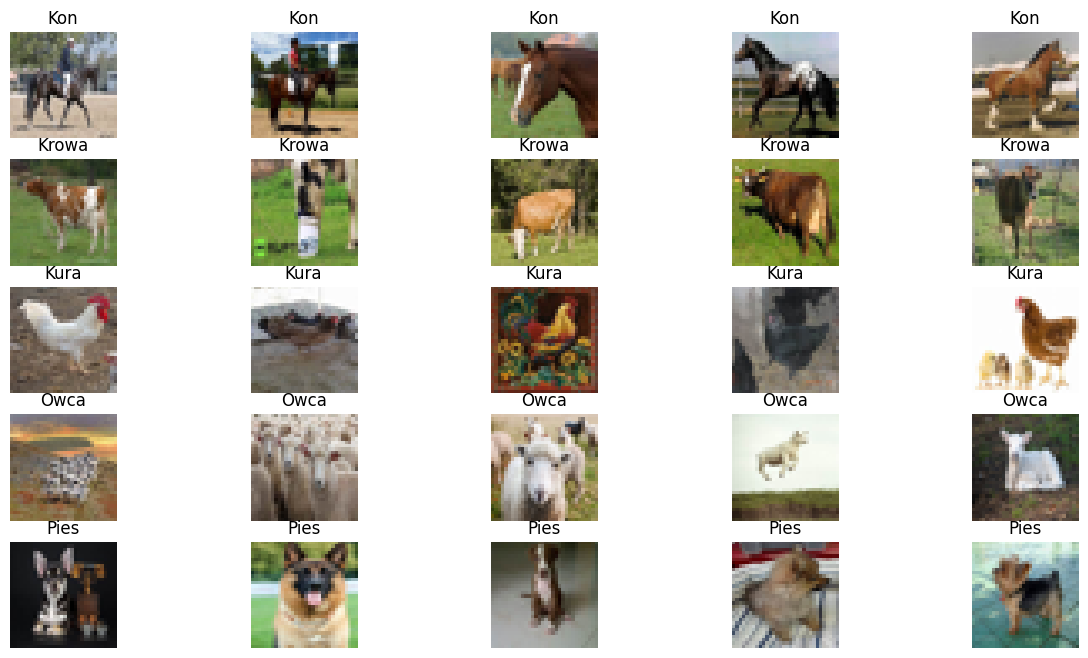

In [3]:
def display_images(images, labels, class_names, num_images=5):
    plt.figure(figsize=(15, 8))
    
    for i, class_name in enumerate(class_names):
        class_indices = np.where(labels == i)[0]
        selected_indices = np.random.choice(class_indices, num_images, replace=False)
        
        for j, idx in enumerate(selected_indices):
            plt.subplot(len(class_names), num_images, i * num_images + j + 1)
            plt.imshow(images[idx])
            plt.title(class_name)
            plt.axis('off')

    plt.show()

# Wyświetl kilka przykładów obrazów
display_images(train_photos, train_labels, nazwy_klas)

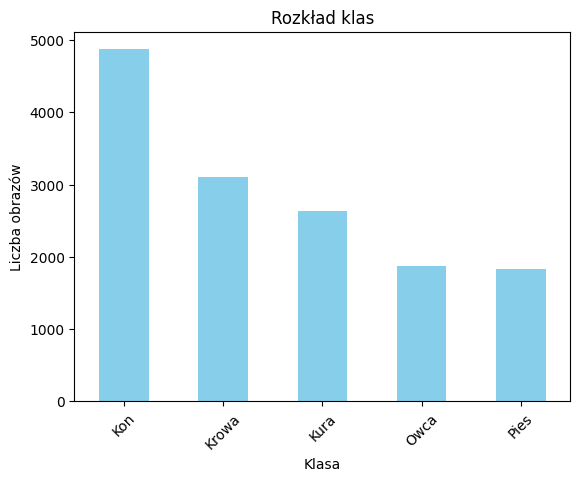

In [4]:
# Analiza rozkładu klas
class_counts = pd.Series(train_labels).value_counts()
class_counts.plot(kind='bar', color='skyblue')
plt.xticks(np.arange(len(nazwy_klas)), nazwy_klas, rotation=45)
plt.xlabel('Klasa')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład klas')
plt.show()

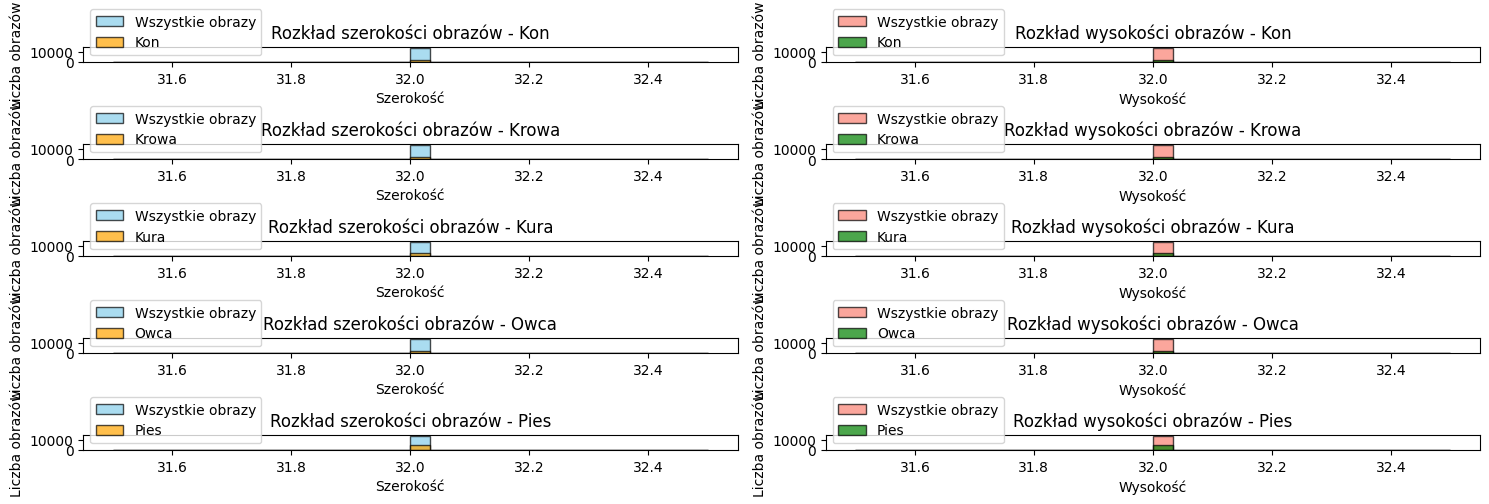

In [6]:
# Analiza rozkładu wielkości obrazów z uwzględnieniem klas
def plot_image_size_distribution_by_class(images, labels, class_names):
    image_sizes = [image.shape for image in images]
    widths = [size[1] for size in image_sizes]
    heights = [size[0] for size in image_sizes]

    plt.figure(figsize=(15, 5))

    for class_idx, class_name in enumerate(class_names):
        class_images = images[labels == class_idx]
        
        plt.subplot(len(class_names), 2, class_idx * 2 + 1)
        plt.hist(widths, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        plt.hist([image.shape[1] for image in class_images], bins=30, color='orange', edgecolor='black', alpha=0.7)
        plt.title(f'Rozkład szerokości obrazów - {class_name}')
        plt.xlabel('Szerokość')
        plt.ylabel('Liczba obrazów')
        plt.legend(['Wszystkie obrazy', f'{class_name}'])

        plt.subplot(len(class_names), 2, class_idx * 2 + 2)
        plt.hist(heights, bins=30, color='salmon', edgecolor='black', alpha=0.7)
        plt.hist([image.shape[0] for image in class_images], bins=30, color='green', edgecolor='black', alpha=0.7)
        plt.title(f'Rozkład wysokości obrazów - {class_name}')
        plt.xlabel('Wysokość')
        plt.ylabel('Liczba obrazów')
        plt.legend(['Wszystkie obrazy', f'{class_name}'])

    plt.tight_layout()
    plt.show()

plot_image_size_distribution_by_class(train_photos, train_labels, nazwy_klas)

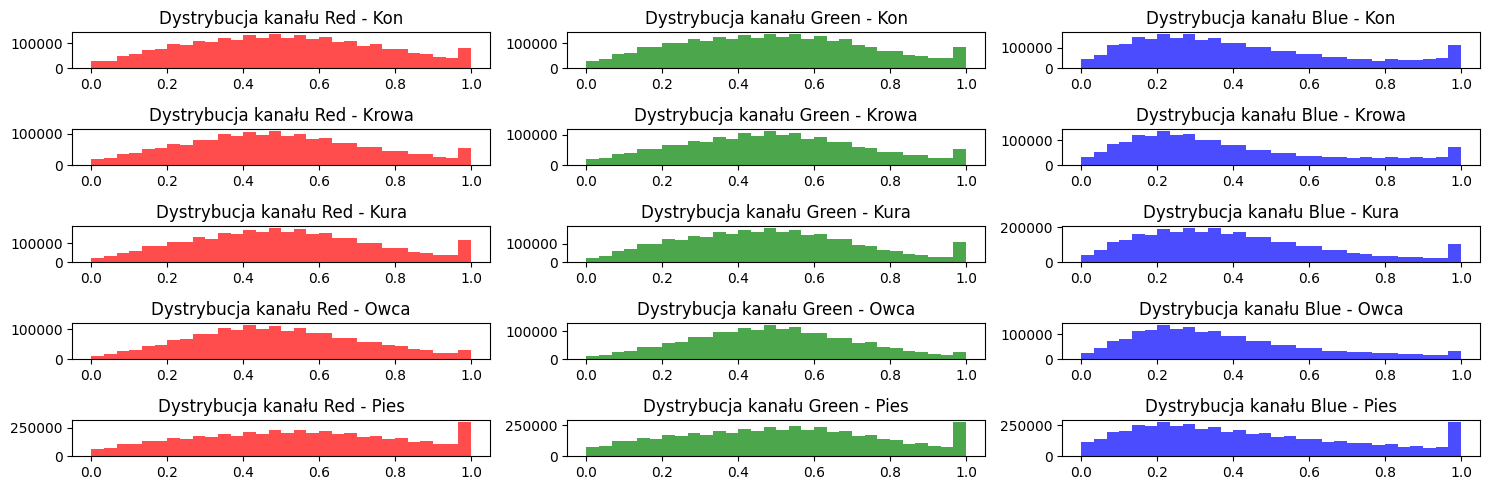

In [7]:
# Analiza rozkładu kanałów kolorów z uwzględnieniem klas
def plot_color_distribution_by_class(images, labels, class_names):
    plt.figure(figsize=(15, 5))

    for class_idx, class_name in enumerate(class_names):
        class_images = images[labels == class_idx]
        for i in range(3):  # Dla każdego kanału kolorów RGB
            plt.subplot(len(class_names), 3, class_idx * 3 + i + 1)
            channel_values = class_images[:, :, :, i].ravel()
            plt.hist(channel_values, bins=30, color=['red', 'green', 'blue'][i], alpha=0.7)
            plt.title(f'Dystrybucja kanału {["Red", "Green", "Blue"][i]} - {class_name}')

    plt.tight_layout()
    plt.show()

# Wywołaj funkcję
plot_color_distribution_by_class(train_photos, train_labels, nazwy_klas)

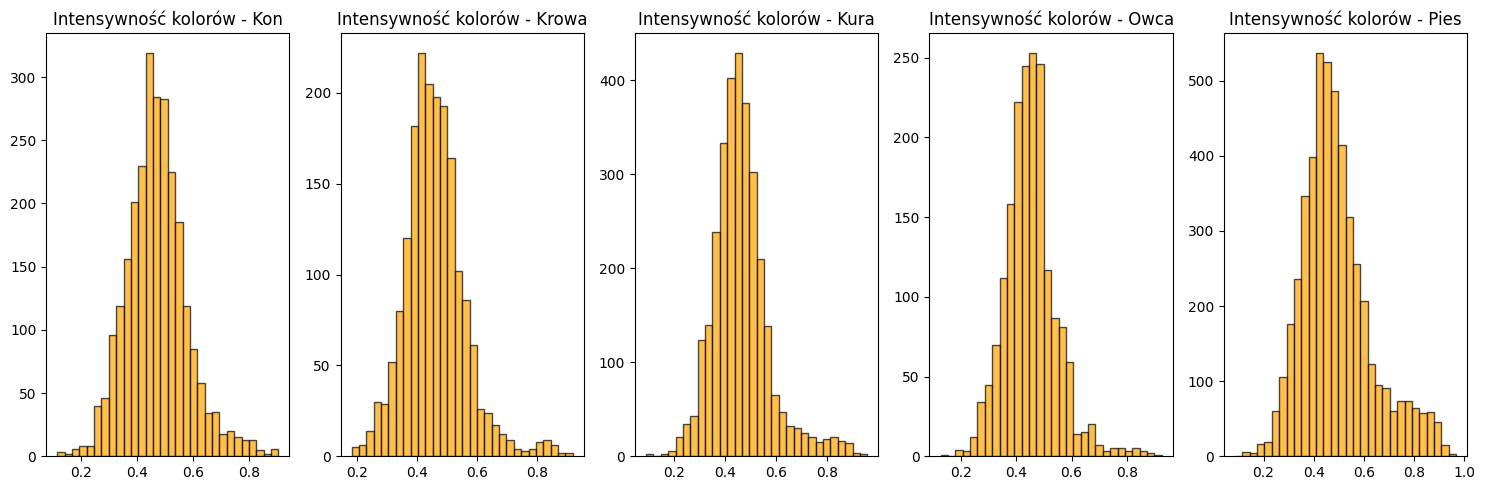

In [3]:
# Analiza rozkładu intensywności kolorów z uwzględnieniem klas
def plot_intensity_distribution_by_class(images, labels, class_names):
    plt.figure(figsize=(15, 5))

    for class_idx, class_name in enumerate(class_names):
        class_images = images[labels == class_idx]
        intensities = np.sum(class_images, axis=(1, 2, 3)) / (class_images.shape[1] * class_images.shape[2] * class_images.shape[3])
        plt.subplot(1, len(class_names), class_idx + 1)
        plt.hist(intensities, bins=30, color='orange', edgecolor='black', alpha=0.7)
        plt.title(f'Intensywność kolorów - {class_name}')

    plt.tight_layout()
    plt.show()

# Wywołaj funkcję
plot_intensity_distribution_by_class(train_photos, train_labels, nazwy_klas)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import joblib
import numpy as np

# Podziel dane na zbiór treningowy i walidacyjny
train_photos, val_photos, train_labels, val_labels = train_test_split(
    train_photos, train_labels, test_size=0.2, random_state=42)

# Funkcja do ekstrakcji cech HOG
def extract_hog_features(images):
    features = []
    for image in images:
        fd, _ = hog(image[:, :, 0], orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True)
        features.append(fd)
    return np.array(features)

# Ekstrakcja cech HOG dla treningu i walidacji
train_features = extract_hog_features(train_photos)
val_features = extract_hog_features(val_photos)

# Standaryzacja cech
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

# Trenowanie i zapisanie modelu SVM
svm_model = SVC(kernel='linear', C=1)
svm_model.fit(train_features, train_labels)
joblib.dump(svm_model, 'svm_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

# Predykcje dla SVM
train_predictions_svm = svm_model.predict(train_features)
val_predictions_svm = svm_model.predict(val_features)

# Dokładność dla SVM
train_accuracy_svm = accuracy_score(train_labels, train_predictions_svm)
val_accuracy_svm = accuracy_score(val_labels, val_predictions_svm)

print(f'Training Accuracy (SVM): {train_accuracy_svm}')
print(f'Validation Accuracy (SVM): {val_accuracy_svm}')


Training Accuracy (SVM): 0.5833987954962032
Validation Accuracy (SVM): 0.4607329842931937


In [12]:
from sklearn.model_selection import cross_val_score
# Definicja różnych wartości hiperparametrów do przetestowania
C_values = [0.1, 1, 10]
kernel_values = ['linear', 'rbf', 'poly']

# Przeprowadzenie walidacji krzyżowej dla różnych kombinacji hiperparametrów
for C in C_values:
    for kernel in kernel_values:
        svm_model = SVC(C=C, kernel=kernel)
        scores = cross_val_score(svm_model, train_features[:1000], train_labels[:1000], cv=5)
        mean_accuracy = np.mean(scores)
        
        print(f'C={C}, kernel={kernel}, Mean Cross-Validated Accuracy:{mean_accuracy}')

C=0.1, kernel=linear, Mean Cross-Validated Accuracy:0.367
C=0.1, kernel=rbf, Mean Cross-Validated Accuracy:0.335
C=0.1, kernel=poly, Mean Cross-Validated Accuracy:0.335
C=1, kernel=linear, Mean Cross-Validated Accuracy:0.367
C=1, kernel=rbf, Mean Cross-Validated Accuracy:0.45499999999999996
C=1, kernel=poly, Mean Cross-Validated Accuracy:0.34
C=10, kernel=linear, Mean Cross-Validated Accuracy:0.367
C=10, kernel=rbf, Mean Cross-Validated Accuracy:0.465
C=10, kernel=poly, Mean Cross-Validated Accuracy:0.376


In [13]:
# Trenowanie i zapisanie modelu SVM
svm_model = SVC(kernel='rbf', C=1)
svm_model.fit(train_features, train_labels)

# Predykcje dla SVM
train_predictions_svm = svm_model.predict(train_features)
val_predictions_svm = svm_model.predict(val_features)

# Dokładność dla SVM
train_accuracy_svm = accuracy_score(train_labels, train_predictions_svm)
val_accuracy_svm = accuracy_score(val_labels, val_predictions_svm)

print(f'Training Accuracy (SVM): {train_accuracy_svm}')
print(f'Validation Accuracy (SVM): {val_accuracy_svm}')

Training Accuracy (SVM): 0.8411451514358035
Validation Accuracy (SVM): 0.5256544502617801


In [14]:
# Trenowanie i zapisanie modelu SVM
svm_model = SVC(kernel='rbf', C=10)
svm_model.fit(train_features, train_labels)

# Predykcje dla SVM
train_predictions_svm = svm_model.predict(train_features)
val_predictions_svm = svm_model.predict(val_features)

# Dokładność dla SVM
train_accuracy_svm = accuracy_score(train_labels, train_predictions_svm)
val_accuracy_svm = accuracy_score(val_labels, val_predictions_svm)

print(f'Training Accuracy (SVM): {train_accuracy_svm}')
print(f'Validation Accuracy (SVM): {val_accuracy_svm}')

Training Accuracy (SVM): 1.0
Validation Accuracy (SVM): 0.5609075043630017


In [28]:

# Przykładowe wartości parametru n_neighbors do przetestowania
neighbors_values = [3, 5, 7, 9, 11, 15, 17, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100]

for n_neighbors in neighbors_values:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    
    # Walidacja krzyżowa dla danego modelu
    scores = cross_val_score(knn_model, train_features, train_labels, cv=5)
    
    # Średnia dokładność dla danej wartości n_neighbors
    mean_accuracy = np.mean(scores)
    
    print(f'n_neighbors = {n_neighbors}, Mean Accuracy: {mean_accuracy}')

n_neighbors = 3, Mean Accuracy: 0.3680726158890202
n_neighbors = 5, Mean Accuracy: 0.37819687478813446
n_neighbors = 7, Mean Accuracy: 0.3829094879957463
n_neighbors = 9, Mean Accuracy: 0.3888444272793685
n_neighbors = 11, Mean Accuracy: 0.3898038686932629
n_neighbors = 15, Mean Accuracy: 0.3894552475236966
n_neighbors = 17, Mean Accuracy: 0.39032769551999136
n_neighbors = 20, Mean Accuracy: 0.38901803323270434
n_neighbors = 25, Mean Accuracy: 0.3912006005745222
n_neighbors = 30, Mean Accuracy: 0.3924218982695013
n_neighbors = 40, Mean Accuracy: 0.3973972056982974
n_neighbors = 50, Mean Accuracy: 0.3942544351788583
n_neighbors = 60, Mean Accuracy: 0.3952150573265293
n_neighbors = 70, Mean Accuracy: 0.3942551207662125
n_neighbors = 80, Mean Accuracy: 0.3939936834551774
n_neighbors = 90, Mean Accuracy: 0.39652525284842505
n_neighbors = 100, Mean Accuracy: 0.39626351083189937


In [16]:
# Trenowanie i zapisanie modelu KNN
knn_model = KNeighborsClassifier(n_neighbors=5) 
knn_model.fit(train_features, train_labels)
joblib.dump(knn_model, 'knn_model.joblib')

# Predykcje dla KNN
train_predictions_knn = knn_model.predict(train_features)
val_predictions_knn = knn_model.predict(val_features)

# Dokładność dla KNN
train_accuracy_knn = accuracy_score(train_labels, train_predictions_knn)
val_accuracy_knn = accuracy_score(val_labels, val_predictions_knn)

print(f'Training Accuracy (KNN): {train_accuracy_knn}')
print(f'Validation Accuracy (KNN): {val_accuracy_knn}')

Training Accuracy (KNN): 0.5806930260975822
Validation Accuracy (KNN): 0.3888307155322862


In [15]:
# Trenowanie i zapisanie modelu KNN
knn_model = KNeighborsClassifier(n_neighbors=28) 
knn_model.fit(train_features, train_labels)
joblib.dump(knn_model, 'knn_model.joblib')

# Predykcje dla KNN
train_predictions_knn = knn_model.predict(train_features)
val_predictions_knn = knn_model.predict(val_features)

# Dokładność dla KNN
train_accuracy_knn = accuracy_score(train_labels, train_predictions_knn)
val_accuracy_knn = accuracy_score(val_labels, val_predictions_knn)

print(f'Training Accuracy (KNN): {train_accuracy_knn}')
print(f'Validation Accuracy (KNN): {val_accuracy_knn}')

Training Accuracy (KNN): 0.45718774548311075
Validation Accuracy (KNN): 0.3968586387434555
